<a href="https://colab.research.google.com/github/jpbaudoin/AprendizajePorRefuerzos/blob/master/lab_1_intro_grupo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

Grupo 3:
- Juan Pablo Baudoin
- Miguel Laborde

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = "X"
        
        grid_pos = 12*row + column
        print(f"Pos: {grid_pos} D: {down_action}, R: {right_action},  L: {left_action}, U: {up_action},")
        print(f"Best action: {arrow_direction}")
        print("-"*35)
        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        
        plt.text(column, row, f"{arrow_direction}({grid_pos})", horizontalalignment="center")
        # plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
# ! pip install gymnasium
# ! pip install pygame

In [3]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
  print("Running in Collab")
  

except:
  IN_COLAB = False
  print("Running in Local Machine")

import gymnasium as gym


Running in Local Machine


In [4]:


# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    # env = gym.make('CartPole-v0', render_mode='human')
    env = gym.make('CartPole-v0')
    env.reset()
    env.render()
    

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [5]:
if not IN_COLAB:
    # env = gym.make('MountainCar-v0', render_mode='human')
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(10):
        env.render()
        action = env.action_space.sample()
        print(action)
        obs, reward, terminated, truncated, info = env.step(action)
        print(obs, reward, terminated, truncated, info)
        done = terminated or truncated
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    # clear_output()

0
[-0.53517604 -0.00092008] -1.0 False False {}
0
[-0.5370093  -0.00183327] -1.0 False False {}
0
[-0.53974205 -0.00273272] -1.0 False False {}
0
[-0.54335374 -0.00361169] -1.0 False False {}
0
[-0.54781735 -0.00446362] -1.0 False False {}
0
[-0.5530995  -0.00528214] -1.0 False False {}
1
[-0.55816066 -0.00506117] -1.0 False False {}
2
[-0.5619631  -0.00380242] -1.0 False False {}
0
[-0.56647843 -0.00451532] -1.0 False False {}
1
[-0.57067305 -0.00419461] -1.0 False False {}


/Users/jbaudoin/.pyenv/versions/3.10.14/envs/mentoria-3.10.14/lib/python3.10/site-packages/gymnasium/envs/classic_control/mountain_car.py:179: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [6]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [7]:
def choose_action_softmax() -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """

    # TODO: implementar
    pass

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

<a id='learn_SARSA_function'>Function Learn_Sarsa</a>

In [8]:
def learn_SARSA(
        state: Any, # COMPLETAR tipo de cada parámetro
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: Any,
        q: Any,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: COMPLETAR
        action: COMPLETAR
        reward: COMPLETAR
        next_state: COMPLETAR
        next_action: COMPLETAR
        hyperparameters: COMPLETAR
        q: COMPLETAR
    """
  
    # Recuperar los hiperparámetros
    alpha = hyperparameters.get("alpha", 0.1)  # Tasa de aprendizaje
    gamma = hyperparameters.get("gamma", 0.99)  # Factor de descuento

    # Valor Q actual
    q_current = q.get((state, action), 0.0)

    # Valor Q futuro (para el siguiente estado y acción)
    q_next = q.get((next_state, next_action), 0.0)

    # Ecuación de actualización de SARSA
    q[state, action] = q_current + alpha * (reward + gamma * q_next - q_current)

    
    pass

<a id='learn_Q_learning_function'>Function Q-Learning</a>

In [9]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
        state: Any, # COMPLETAR tipo de cada parámetro
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: Any,
        q: Any,
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args: COMPLETAR
    """

    alpha = hyperparameters.get("alpha", 0.1)  # Tasa de aprendizaje
    gamma = hyperparameters.get("gamma", 0.99)  # Factor de descuento

    # Valor Q actual
    q_current = q.get((state, action), 0.0)

    # Valor Q futuro (para el siguiente estado y acción)
    # q_next = q.get((next_state, next_action), 0.0)
    
    down_action  = q.get((next_state, 2), 0.0)
    left_action  = q.get((next_state, 3), 0.0)
    right_action = q.get((next_state, 1), 0.0)
    up_action    = q.get((next_state, 0), 0.0)

    q_next = max(left_action, down_action, right_action, up_action)

    q[state, action] = q_current + alpha * (reward + gamma * q_next - q_current)

    pass

Finalmente, definimos el método principal de iteraciones.

In [10]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
    actions_mapping={}
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []
    actions_of_episode = []

    for episode_no in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()
        episode_reward = 0
        done = False
        t = 0
        action_list = []
        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)
        action_list.append(action)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # print(f"Cur q: {q}")
            
            # print(f"Cur state: {state}")
            # print(f"action: {action}")
            # print(f"Next state: {next_state}")

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)
            
            # print(f"Next Action: {next_action}")
            # print(f"Reward: {reward}")

            episode_reward += reward

            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )
            # print(f"New Cur q: {q}")

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
                action_list.append(actions_mapping.get(action,action))
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )
                actions_of_episode.append(action_list)

            t += 1
            # print(f"Step: {t}")
            # print("-"*25)
        # print(f"Episode {episode_no} q: {q}")
        
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode, actions_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [11]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)


# definimos sus híper-parámetros básicos
# hyperparameters = {
#     "alpha": 1,         # Tasa de aprendizaje
#     "gamma": 2,         # Factor de descuento
#     "epsilon": 0.2,     # Probabilidad de exploración
#     "tau": 25,
# }

# hyperparameters = {
#     "alpha": 0.2,
#     "gamma": 0.99,
#     "epsilon": 0.2,
#     "tau": 25,
# }



# hyperparameters = {
#     "alpha": 0.1,
#     "gamma": 0.99,
#     "epsilon": 0.2,
#     "tau": 25,
# }
# # hyperparameters = {
# #     "alpha": 0.5,
# #     "gamma": 1,
# #     "epsilon": 0.1,
# #     "tau": 25,
# # }

# # se puede cambiar por learn_Q_learning, una vez que se implemente
# learning_function = learn_SARSA
# episodes_to_run = 33500

# env = gym.make("CliffWalking-v0", render_mode='human')
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)
actions_mappings = {
    0: "UP",
    1: "RIGHT",
    2: "DOWN",
    3: "LEFT"
}


# se declara una semilla aleatoria
# random_state = np.random.RandomState(42)
random_state = np.random.RandomState(1)

In [12]:
from itertools import product
import json

def generate_combinations(params, learning_functions):

    normalized_params = {k: v if isinstance(v, list) else [v] for k, v in params.items()}

    keys = normalized_params.keys()
    values = normalized_params.values()
    


    combinations = [{'params': dict(zip(keys, combo))} for combo in product(*values)]
    for combo in combinations:
        combo['name'] = '_'.join([f"{k}_{v}" for k, v in combo['params'].items()])
    
    for lf in learning_functions:
        lf['experiments'] = combinations
    return learning_functions

In [13]:
hyperparameters_ops = {
    "alpha":   [0.4,  0.05],     # Tasa de Aprendizaje:
                                # Rango Típico: 0.01 ≤ 𝛼 ≤ 0.5
                                # Alto: aprendizaje rápido, olvidando rápidamente
                                # Bajo: aprendizaje lento, olvidando lentamente

    "gamma":   [0.99, 0.9],     # Factor de Descuento:
                                # Rango Típico: 0.8 ≤ 𝛾 ≤ 0.99. 
                                # Alto: aprendizaje en maximizar las recompensas acumuladas a largo plazo
                                # Bajo: aprendizaje en maximizar las recompensas inmediatas

    "epsilon": [0.8, 0.5, 0.1], # alto favorece la exploración, bajo favorece la explotación
    # "tau": 25,
}

# hyperparameters_ops = {
#     "alpha":   [1],
#     "gamma":   [1],
#     "epsilon": [0.5],
#     # "tau": 25,
# }

learning_functions = [ {'name': "Sarsa", 'funct': learn_SARSA},
                       {'name': "Q-learning", 'funct': learn_Q_learning}]

# learning_functions = [ {'name': "Sarsa", 'funct': learn_SARSA} ]
# learning_functions = [ {'name': "Q-learning", 'funct': learn_Q_learning}]



experiment_list = generate_combinations(hyperparameters_ops, learning_functions)

experiment_list

[{'name': 'Sarsa',
  'funct': <function __main__.learn_SARSA(state: Any, action: Any, reward: Any, next_state: Any, next_action: Any, hyperparameters: Any, q: Any) -> None>,
  'experiments': [{'params': {'alpha': 0.4, 'gamma': 0.99, 'epsilon': 0.8},
    'name': 'alpha_0.4_gamma_0.99_epsilon_0.8'},
   {'params': {'alpha': 0.4, 'gamma': 0.99, 'epsilon': 0.5},
    'name': 'alpha_0.4_gamma_0.99_epsilon_0.5'},
   {'params': {'alpha': 0.4, 'gamma': 0.99, 'epsilon': 0.1},
    'name': 'alpha_0.4_gamma_0.99_epsilon_0.1'},
   {'params': {'alpha': 0.4, 'gamma': 0.9, 'epsilon': 0.8},
    'name': 'alpha_0.4_gamma_0.9_epsilon_0.8'},
   {'params': {'alpha': 0.4, 'gamma': 0.9, 'epsilon': 0.5},
    'name': 'alpha_0.4_gamma_0.9_epsilon_0.5'},
   {'params': {'alpha': 0.4, 'gamma': 0.9, 'epsilon': 0.1},
    'name': 'alpha_0.4_gamma_0.9_epsilon_0.1'},
   {'params': {'alpha': 0.05, 'gamma': 0.99, 'epsilon': 0.8},
    'name': 'alpha_0.05_gamma_0.99_epsilon_0.8'},
   {'params': {'alpha': 0.05, 'gamma': 0.99, 

In [14]:
def best_actions_experiment(experiment_results):
    reward_ep = experiment_results['reward_ep']
    executed_actions = experiment_results['actions_ep']
    max_reward = max(reward_ep)
    i = reward_ep.tolist().index(max_reward)
    # print("La mejor recompensa fue de: ", max_reward)
    # print("Las acciones de este episodio fueron: ")
    # print(executed_actions[i])
    result = {
     "actions":   executed_actions[i],
     "reward":    max_reward,
     "idx":       i
    }
    return result


In [15]:
def run_experiments(experiment_list, episodes_to_run, env, actions, actions_mappings):
    results_experiments = {}
    for lf_hyperparameters in experiment_list:
        learning_function = lf_hyperparameters['funct']
        learning_function_name = lf_hyperparameters['name']
        print(f"Running {learning_function_name}")
        for experiment in lf_hyperparameters['experiments']:
            experiment_name = experiment['name']
            print(f"   Params: {experiment['name']}")
            hyperparameters = experiment['params']
            if experiment_name not in results_experiments:
                results_experiments[experiment_name] = {}
                results_experiments[experiment_name]['l_functions'] = {}

            q = {}
            avg_steps_per_episode, timesteps_ep, reward_ep, executed_actions = run(
                learning_function,
                hyperparameters,
                episodes_to_run,
                env,
                actions,
                q,
                random_state,
                actions_mappings
            )

            results = {
                'reward': avg_steps_per_episode,
                'timesteps_ep': timesteps_ep,
                'reward_ep': reward_ep,
                'actions_ep': executed_actions,
                'hyperparameters': hyperparameters,
                'learning_function': learning_function,
                'lf_name': learning_function_name,
                'q': q
            }
            results['best_actions'] = best_actions_experiment(results)
            results_experiments[experiment_name]['episodes_to_run'] = episodes_to_run
            results_experiments[experiment_name]['l_functions'][learning_function_name] = results
            # experiment['episodes_to_run'] = episodes_to_run
            # experiment['results'] = results.copy()
            print(results['reward'])
                
        print()
    return results_experiments

In [16]:
episodes_to_run = 500
results_experiments = run_experiments(experiment_list, episodes_to_run, env, actions, actions_mappings)

Running Sarsa
   Params: alpha_0.4_gamma_0.99_epsilon_0.8
-96.744
   Params: alpha_0.4_gamma_0.99_epsilon_0.5
-70.548
   Params: alpha_0.4_gamma_0.99_epsilon_0.1
-28.344
   Params: alpha_0.4_gamma_0.9_epsilon_0.8
-99.388
   Params: alpha_0.4_gamma_0.9_epsilon_0.5
-83.986
   Params: alpha_0.4_gamma_0.9_epsilon_0.1
-26.796
   Params: alpha_0.05_gamma_0.99_epsilon_0.8
-95.724
   Params: alpha_0.05_gamma_0.99_epsilon_0.5
-66.898
   Params: alpha_0.05_gamma_0.99_epsilon_0.1
-46.218
   Params: alpha_0.05_gamma_0.9_epsilon_0.8
-97.164
   Params: alpha_0.05_gamma_0.9_epsilon_0.5
-68.002
   Params: alpha_0.05_gamma_0.9_epsilon_0.1
-44.508

Running Q-learning
   Params: alpha_0.4_gamma_0.99_epsilon_0.8
-99.332
   Params: alpha_0.4_gamma_0.99_epsilon_0.5
-85.37
   Params: alpha_0.4_gamma_0.99_epsilon_0.1
-37.996
   Params: alpha_0.4_gamma_0.9_epsilon_0.8
-99.0
   Params: alpha_0.4_gamma_0.9_epsilon_0.5
-85.698
   Params: alpha_0.4_gamma_0.9_epsilon_0.1
-37.628
   Params: alpha_0.05_gamma_0.99_eps

In [17]:
results_experiments.keys()
#loop para imprimir los resultados de los experimentos
for experiment_name, experiment_results in results_experiments.items():
    print(f"Experiment: {experiment_name}")
    
    print(f"Episodes to run: {experiment_results['episodes_to_run']}")
    print(f"Learning function: {experiment_results['l_functions'].keys()}")
    print(f"Learning function: {experiment_results['l_functions']['Sarsa'].keys()}")

    print(f"Best reward Sarsa: {experiment_results['l_functions']['Sarsa']['best_actions']['reward']}")
    print(f"Best actions Sarsa: {experiment_results['l_functions']['Sarsa']['best_actions']['actions']}")
    
    print(f"Best reward Q-learning: {experiment_results['l_functions']['Q-learning']['best_actions']['reward']}")
    print(f"Best actions Q-learning: {experiment_results['l_functions']['Q-learning']['best_actions']['actions']}")
        
    print()

Experiment: alpha_0.4_gamma_0.99_epsilon_0.8
Episodes to run: 500
Learning function: dict_keys(['Sarsa', 'Q-learning'])
Learning function: dict_keys(['reward', 'timesteps_ep', 'reward_ep', 'actions_ep', 'hyperparameters', 'learning_function', 'lf_name', 'q', 'best_actions'])
Best reward Sarsa: -31.0
Best actions Sarsa: [0, 'UP', 'DOWN', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'LEFT', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'UP', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'DOWN', 'DOWN', 'RIGHT', 'DOWN']
Best reward Q-learning: -21.0
Best actions Q-learning: [0, 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'LEFT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'LEFT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

Experiment: alpha_0.4_gamma_0.99_epsilon_0.5
Episodes to run: 500
Learning function: dict_keys(['Sarsa', 'Q-learning'])
Learning function: dict_keys(['reward', 'timesteps_ep', 'reward_ep', 'actions_ep', '

In [18]:
# experiment_results['l_functions']['Sarsa']['reward']
# print(results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions']['Sarsa'].keys())
# print(results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions'].keys())

In [29]:
def plot_reward_per_episode_sp(ax, experiment_function_results, subplot_title) -> None:
    """
    Plots the accumulated reward per episode for multiple series on the same subplot.

    Parameters:
    ax : matplotlib.axes.Axes
        The subplot axes on which to draw the plots.
    reward_ep_list : list of lists or array-like
        A list of rewards per episode for multiple series.
    legend_names : list of str
        Names corresponding to each reward series for the legend.
    subplot_title : str
        Title of the subplot.
    """
    for func, f_results in experiment_function_results.items():
        episode_rewards = np.array(f_results['reward_ep'])
        name = f_results['lf_name']

        # Smooth the convergence curve
        episode_number = np.linspace(
            1, len(episode_rewards) + 1, len(episode_rewards) + 1)
        accumulated_rewards = np.cumsum(episode_rewards)

        reward_per_episode = [
            accumulated_rewards[i] / episode_number[i]
            for i in range(len(accumulated_rewards))
        ]

        # Plot each series
        ax.plot(reward_per_episode, label=name)

    # Set title, labels, and legend
    ax.set_title(subplot_title, loc="center", fontsize=10)
    ax.set_xlabel("Episodio")
    ax.set_ylabel("Recompensa acumulada")
    ax.legend()


In [ ]:
def plot_steps_per_episode_sp(ax, experiment_function_results, subplot_title) -> None:

    for func, f_results in experiment_function_results.items():
        # se muestra la curva de aprendizaje de los pasos por episodio
        episode_steps = np.array(f_results['timesteps_ep'])       
        name = f_results['lf_name']


        ax.plot(np.array(range(0, len(episode_steps))), episode_steps, label=name)
        ax.set_title(f"Pasos (timesteps) por episodio\n({subplot_title})", loc="center", fontsize=10)
        ax.set_xlabel("Episodio")
        ax.set_ylabel("Pasos (timesteps)")
        ax.legend()



def plot_steps_per_episode_smooth_sp(ax, experiment_function_results, subplot_title) -> None:

    for func, f_results in experiment_function_results.items():
        # se muestra la curva de aprendizaje de los pasos por episodio
        episode_steps = np.array(f_results['timesteps_ep'])
        name = f_results['lf_name']

        episode_number = np.linspace(
            1, len(episode_steps) + 1, len(episode_steps) + 1)
        acumulated_steps = np.cumsum(episode_steps)

        steps_per_episode = [
            acumulated_steps[i] / episode_number[i] for i in range(
                len(acumulated_steps))
        ]


        ax.plot(steps_per_episode, label=name)
        ax.set_title(f"Pasos (timesteps) por episodio - Smooth\n({subplot_title})", loc="center", fontsize=10)
        ax.set_xlabel("Episodio")
        ax.set_ylabel("Pasos (timesteps)")
        ax.legend()


In [21]:
def plot_experiment(plot_func, results_experiments ):

    nrows = len(results_experiments)
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(5, 4*nrows))
    row = 0
    for experiment_name, experiment_result in results_experiments.items():
        
        subplot_title = experiment_name
        # subplot_title = experiment_list[j]['experiments'][i]['name']
        if nrows == 1:
            plot_func(axs, experiment_result['l_functions'], subplot_title ) 
        else:    
            plot_func(axs[row], experiment_result['l_functions'], subplot_title ) 

        row += 1

    plt.tight_layout()
    plt.show()
    


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def draw_value_matrix2(ax, q, title="") -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # Calculate the value matrix
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = [
                q.get((row * n_columns + column, action), -100)
                for action in range(n_actions)
            ]
            q_value_matrix[row, column] = max(state_values)

    # Set goal state's value to -1 for appropriate coloring
    q_value_matrix[3, 11] = -1

    # Plot the matrix on the provided axis
    im = ax.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    ax.set_title(title, fontsize=10)

    # Add direction indicators
    for row, column in itertools.product(range(n_rows), range(n_columns)):
        actions = {
            "L": q.get((row * n_columns + column, 3), -1000),
            "D": q.get((row * n_columns + column, 2), -1000),
            "R": q.get((row * n_columns + column, 1), -1000),
            "U": q.get((row * n_columns + column, 0), -1000),
        }
        arrow_direction, best_action = max(actions.items(), key=lambda x: x[1])
        if best_action == -1:
            arrow_direction = "X"

        grid_pos = 12 * row + column
        ax.text(
            column, row, f"{arrow_direction}({grid_pos})",
            horizontalalignment="center",
            fontsize=7
        )

    ax.set_xticks([])
    ax.set_yticks([])
    return im

def draw_value_matrix_experiments(results_experiments):
    # Calculate grid dimensions
    num_experiments = len(results_experiments)
    num_functions = max(len(exp["l_functions"]) for exp in results_experiments.values())

    # Set up the subplots
    fig, axes = plt.subplots(
        num_experiments, num_functions,
        figsize=(6 * num_functions, 3 * num_experiments),
        squeeze=False
    )

    for i, (experiment_name, experiment_results) in enumerate(results_experiments.items()):
        for j, (lf_name, lf_results) in enumerate(experiment_results['l_functions'].items()):
            q = lf_results['q']
            title = f"{experiment_name} - {lf_name}"

            ax = axes[i, j]
            im = draw_value_matrix2(ax, q, title)
            # Add a single colorbar
            cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.01, use_gridspec=True)
            cbar.set_label("Q-value")

    
    # Adjust layout
    plt.tight_layout()
    plt.show()


### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

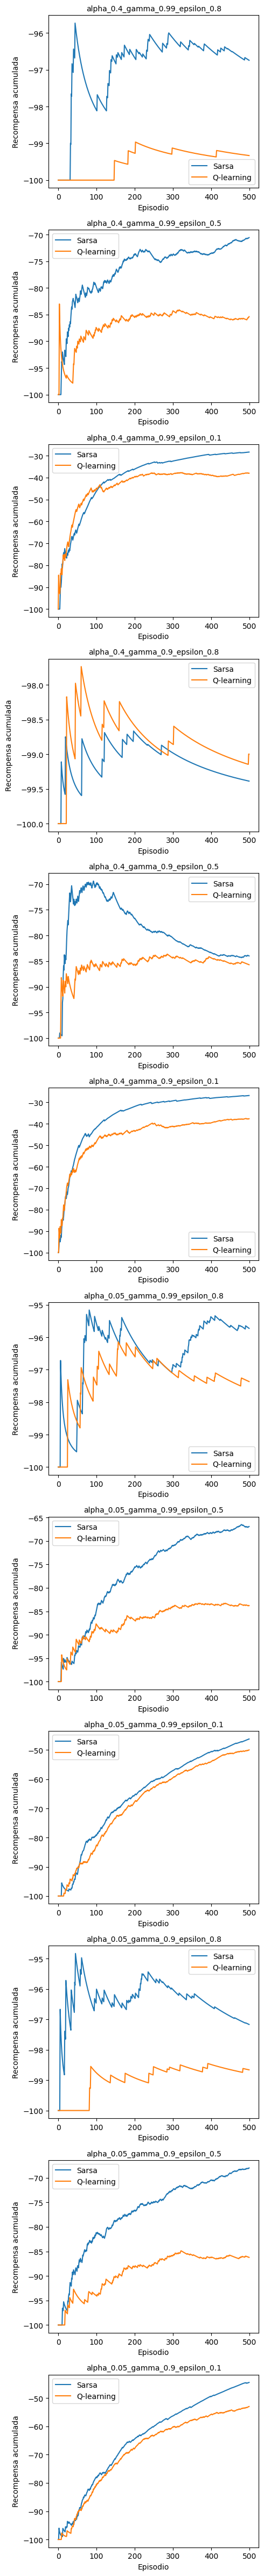

In [30]:
plot_experiment(plot_reward_per_episode_sp, results_experiments)

Veamos pasos por episodio

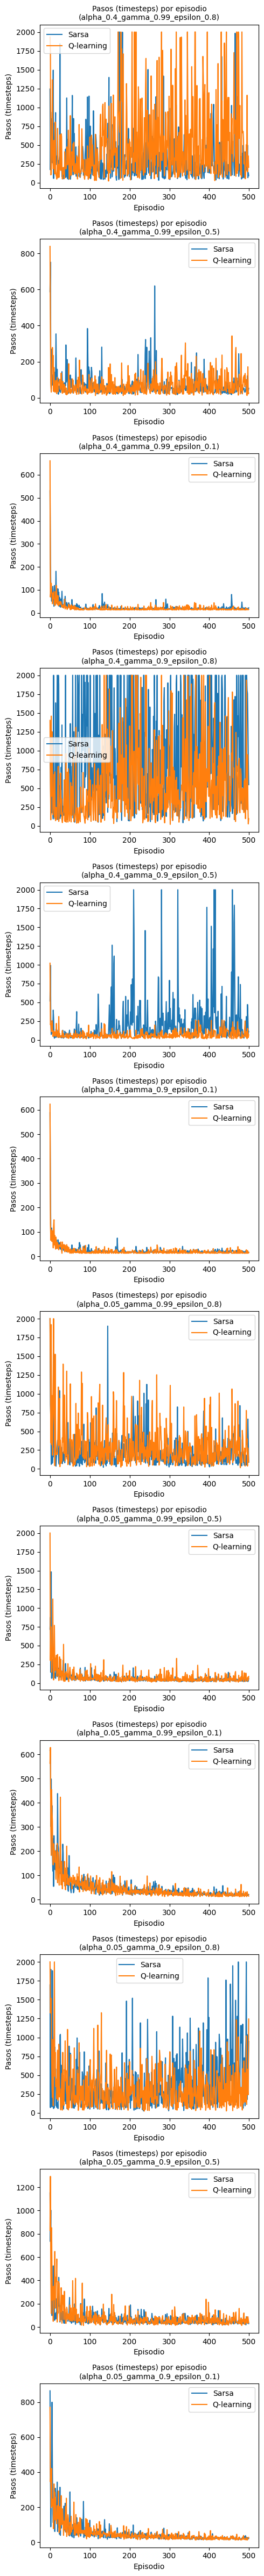

In [24]:
plot_experiment(plot_steps_per_episode_sp, results_experiments)

Suavizando...

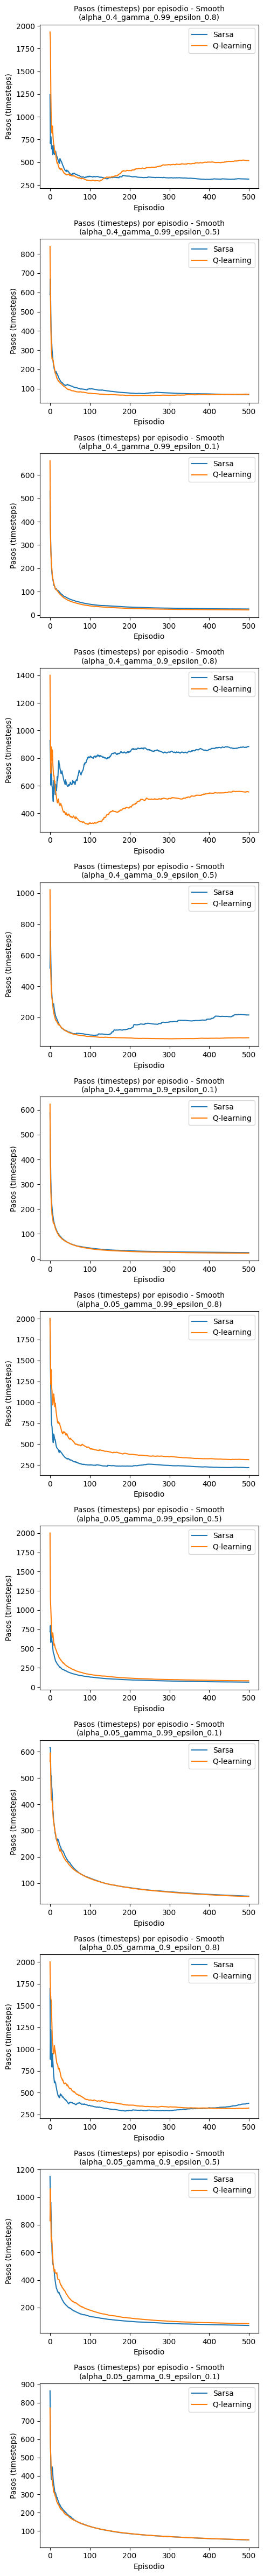

In [25]:

plot_experiment(plot_steps_per_episode_smooth_sp, results_experiments)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

In [26]:
# results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions']['Sarsa'].keys()

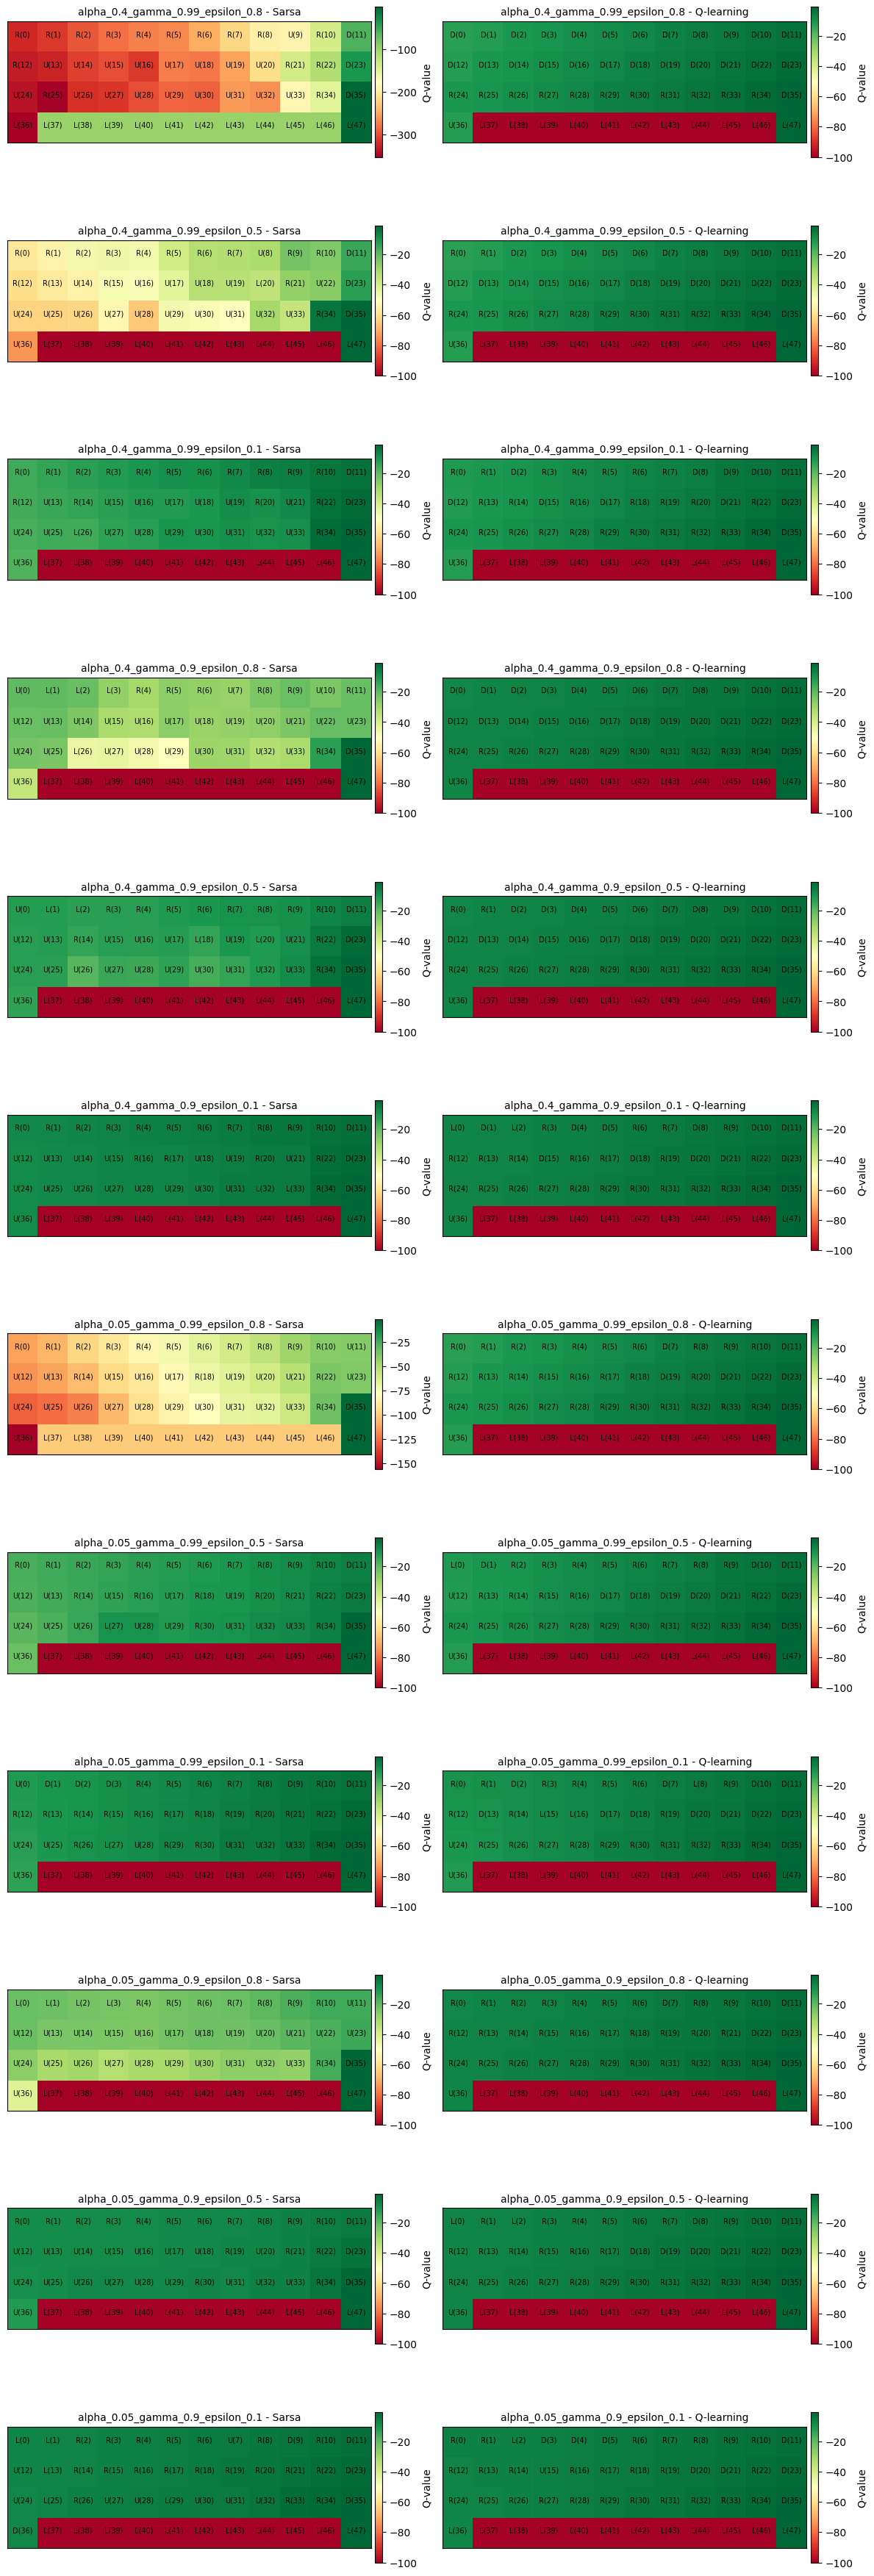

In [27]:
# q_sarsa = results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions']['Sarsa']['q']
# q_ql = results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions']['Q-learning']['q']

# results_experiments['alpha_0.2_gamma_0.99_epsilon_0.2']['l_functions']['Sarsa'].keys()
# # print(q)
# draw_value_matrix(q_sarsa)
# draw_value_matrix(q_ql)

draw_value_matrix_experiments(results_experiments)

In [28]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".
    * Función learn_SARSA en la celda 8

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.
    * Función learn_Q_learning en la celda 9
    * Q-learning converge mucho más rapido que SARSA, ademas, logra encontrar el camino optimo al destino.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

Q-Learning generalmente tuvo un mejor rendimiento que SARSA ya que converge en general más rápido. Entendemos que esto es debido a que es un algoritmo off-policy que busca aprender utilizando las máximas recompensas futuras.

Con SARSA encontramos que es bastante más suceptible a los hiperparámetros enviados, encontrando episodios con comportamientos muy irregulares. Particularmente los episodios con Gamma y Epsilon altos, generaron mayor exploración y menor convergerncia

En ambos la tasa de aprendizaje tuvo prácticamente la misma influencia. Una tasa de aprendizaje más alta llevó a un aprendizaje más rápido pero también causó variaciones en la recompensa (Episodios 1, 2 y 4 en SARSA). Una tasa de aprendizaje más baja resultó en un aprendizaje más estable pero una convergencia más lenta.

Notas respecto a la convergencia:

Ambos algoritmos mostraron convergencia con el tiempo, pero Q-Learning convergió más rápido y a una mejor política en comparación con SARSA.
La convergencia varió considreablemente según la elección de los hiperparámetros, con ciertas combinaciones llevando a un mejor resultado.

Entendemos que para este problema "The Cliff" el mejor algoritmo es Q-Learning debido que es off-policy, utilizando la máxima recompensa del siguiente episodio y su convergencia más rápida.


**PREGUNTAS** 

De este trabajo nos surgieron las siguientes inquietudes:

- ¿Por que hay un episodio intermendio con mejor recompensa que la final?
- ¿Puede ser que la politica empeore? Quizas depende de cuanta exploración se realiza.
- Por que razon no converge a la mejor alternativa? 
  * ¿es cuestion del numero de episodios?
  * ¿Ajuste de hyperparametros?
  * ¿Funcion de aprendizaje?

- ¿Que condición nos indica que encontramos la politica optima? ¿Podemos dejar de explorar a partir de ese momento?

- Notamos en en varios casos de la matriz de valores, hay movimientos que no deberían ser validos ¿Por que se da esto?. Ejemplos:
  * En el experimento alpha_0.05_gamma_0.9_epsilon0.1 - Q-learning, celda36, movimiento: L
  * En el experimento alpha_0.05_gamma_0.9_epsilon0.1 - Sarsa, celda36, movimiento: D
  * En el experimento alpha_0.05_gamma_0.09_epsilon0.1 - Sarsa, celda0, movimiento: U